## Занятие по уроку Титаник

In [ ]:
import pandas as pd
import numpy as np
from sklearn import tree
%matplotlib inline

In [ ]:
titanic_data = pd.read_csv('./train.csv')
titanic_data.head()

# Проверка на наличие нанов

In [6]:
titanic_data.isnull().sum()

PassengerId 0
Survived 0
Pclass 0
Name 0
Sex 0
Age 177
SibSp 0
Parch 0
Ticket 0
Fare 0
Cabin 687
Embarked 2
dtype: int64

In [7]:
# Удалить нерелевантные для определения выживаемости данные
X = titanic_data.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
Y = titanic_data.Survived

## Предобработка данных

In [8]:
X = pd.get_dummies(X) # Деление male/female на 0 и 1
X = X.fillna({ 'Age': X.Age.median() })

X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


## Инициализация классификатора DecisionTreeClassifier

In [9]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)

## Деление даты на чанки

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

Для того чтобы проверить как классификатор научился распозновать паттерны (закономерности) можно обучить на тесте и проверить скор на данных которые классификатор не видел.

In [12]:
clf.fit(X_train, Y_train)
clf.score(X_test, Y_test)

0.8067796610169492

## Кроссвалидация

Датасеты - train dataset используется для тренировки модели, validation - для её проверки, тестовый датасет выступает как ещё один уровень проверки, которая происходит на не показанных модели ранее данных

In [13]:
from sklearn.model_selection import cross_val_score

In [14]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [15]:
np.median(cross_val_score(clf, X_train, Y_train, cv=5))

0.7916666666666666

## Завод по подбору параметров GridSearch

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn import tree

In [17]:
clf = tree.DecisionTreeClassifier()
grid_search_clf = GridSearchCV(clf, {'criterion': ['gini', 'entropy'], 'max_depth': range(1,30)}, cv=5)
grid_search_clf.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 30)})

In [18]:
grid_search_clf.best_params_
best_clf = grid_search_clf.best_estimator_
predicted = best_clf.predict(X_test)

## Precision и Recall

<img src="./Type-I-and-II-errors1-625x468.jpg" />

Чтобы посчитать **Precision** надо выполнить такую формулу $\Large\frac{TP}{TP + FP}$, а для Recall соответственно $\Large\frac{TN}{TN + FN}$. Например, есть 9 пассажиров Титаника из них 6 выжили и 3 нет. Модель отметила что выжили 7 и 2 нет. Значит Precission $\Large\frac{6}{6 + 1} = 85%$, а Recall $\Large\frac{2}{2 + 0} = 100%$.

В разных случаях можно тюнить разные показатели.

In [19]:
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
from sklearn.metrics import precision_score, recall_score, f1_score

In [20]:
message = f'Precision равен {precision_score(Y_test, predicted)}, Recall равен {recall_score(Y_test, predicted)} и F-мера {f1_score(Y_test, predicted)}'
print(message)

Precision равен 0.75, Recall равен 0.65 и F-мера 0.6964285714285715


### Тюнинг precission и recall для модели

<AxesSubplot:>

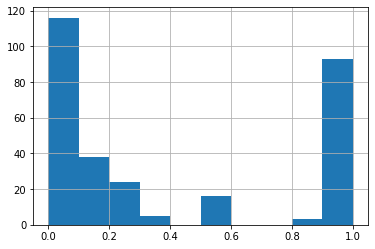

In [21]:
# Вероятность отнессения к классу выживших
pd.Series(best_clf.predict_proba(X_test)[:, 1]).hist()

In [22]:
message = f'Precision равен {precision_score(Y_test, predicted)}, Recall равен {recall_score(Y_test, predicted)} и F-мера {f1_score(Y_test, predicted)}'
print(message)

Precision равен 0.75, Recall равен 0.65 и F-мера 0.6964285714285715


In [33]:
# По умолчанию если шанс отнести к 1 больше 50% то это 1, если нет то 0. Но, если сделать эти проценты вероятности строже, то можно повлиять на precssion score и на recall.
# Для начала поднимем Precission score
improved_precission = np.where(best_clf.predict_proba(X_test)[:, 1] > 0.95, 1, 0)
print(f'Если относить к выжившим всех у кого шанс выжить > 95%, тогда Precission score будет {precision_score(Y_test, improved_precission)}, но recall {recall_score(Y_test, improved_precission)}')
improved_recall = np.where(best_clf.predict_proba(X_test)[:, 1] > 0.05, 1, 0)
print(f'Если относить к выжившим всех у кого шанс выжить > 5%, тогда Precission score будет {precision_score(Y_test, improved_recall)}, но recall {recall_score(Y_test, improved_recall)}')

Если относить к выжившим всех у кого шанс выжить > 95%, тогда Precission score будет 0.7956989247311828, но recall 0.6166666666666667
Если относить к выжившим всех у кого шанс выжить > 5%, тогда Precission score будет 0.5439560439560439, но recall 0.825


## ROC и auc

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [52]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

In [34]:
fpr, tpr, threshold = roc_curve(Y_test, best_clf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

## Полный эксперимент с заполнением возраста из обученной модели DecissionTreeRegressions

Цель сравнить точность предсказания с возрастом заполненным median'ым значением и предсказанным значением

In [110]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [111]:
titanic_data = pd.read_csv("./train.csv")
# titanic_data = titanic_data.set_index('PassengerId')

# Change type of values for Sex column
titanic_data['Sex'] = np.where(titanic_data['Sex'] == 'female', 0, 1)

# Remove rows with NaN in age
rows_witn_unknown_age = titanic_data[np.isnan(titanic_data.Age)]
rows_witn_known_age = titanic_data[np.isnan(titanic_data.Age) == False]

### Обучение дерева_регресии для предсказания возраста

In [112]:
X = rows_witn_known_age.get(['Survived', 'Sex', 'Pclass'])
Y = rows_witn_known_age.Age

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

regressor_clf = DecisionTreeRegressor()
regressor_clf.fit(X_train, Y_train)

predicted_ages = regressor_clf.predict(rows_witn_unknown_age.get(['Survived', 'Sex', 'Pclass']))
rows_witn_unknown_age.loc[:,'Age'] = predicted_ages

titanic_data_with_age = rows_witn_known_age.merge(rows_witn_unknown_age, how='outer')

/opt/python/envs/default/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


### Использование выборки с возрастом

In [125]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [126]:
X = titanic_data_with_age.get(['Pclass', 'Sex', 'Age'])
Y = titanic_data_with_age.Survived

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

grid_search_clf = GridSearchCV(DecisionTreeClassifier(), {'max_depth': [5, 7, 10, 13, 15]})
grid_search_clf.fit(X_train, Y_train)

predicted = grid_search_clf.best_estimator_.predict(X_test)

print(f'Precision: {precision_score(Y_test, predicted)}')
print(f'Recall равен {recall_score(Y_test, predicted)}')
print(f'F1-мера {f1_score(Y_test, predicted)}')
print(f'Accuracy {accuracy_score(Y_test, predicted)}')

Precision: 0.8247422680412371
Recall равен 0.6896551724137931
F1-мера 0.7511737089201878
Accuracy 0.8203389830508474


### Предсказание при помощи обычного дерева с медианным значением возраста где было пусто

In [129]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import numpy as np

In [141]:
titanic_data = pd.read_csv("./train.csv")
titanic_data['Sex'] = np.where(titanic_data['Sex'] == 'female', 0, 1)

X = titanic_data.get(['Pclass', 'Sex', 'Age'])
Y = titanic_data.Survived

X = X.fillna({ 'Age': X.Age.median() })

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

grid_search_clf = GridSearchCV(DecisionTreeClassifier(), {'max_depth': [5, 7, 10, 13, 15]})
grid_search_clf.fit(X_train, Y_train)

predicted = grid_search_clf.best_estimator_.predict(X_test)

print(f'Precision: {precision_score(Y_test, predicted)}')
print(f'Recall равен {recall_score(Y_test, predicted)}')
print(f'F1-мера {f1_score(Y_test, predicted)}')
print(f'Accuracy {accuracy_score(Y_test, predicted)}')

Precision: 0.8840579710144928
Recall равен 0.5083333333333333
F1-мера 0.6455026455026456
Accuracy 0.7728813559322034


### Предсказание при помощи леса с медианным возрастом

In [143]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import numpy as np

In [144]:
titanic_data = pd.read_csv("./train.csv")
titanic_data['Sex'] = np.where(titanic_data['Sex'] == 'female', 0, 1)

X = titanic_data.get(['Pclass', 'Sex', 'Age'])
Y = titanic_data.Survived

X = X.fillna({ 'Age': X.Age.median() })

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

grid_search_clf = GridSearchCV(RandomForestClassifier(), {'n_estimators': [10,20,30], 'max_depth': [5, 7, 10, 13, 15]})
grid_search_clf.fit(X_train, Y_train)

predicted = grid_search_clf.best_estimator_.predict(X_test)

print(f'Precision: {precision_score(Y_test, predicted)}')
print(f'Recall равен {recall_score(Y_test, predicted)}')
print(f'F1-мера {f1_score(Y_test, predicted)}')
print(f'Accuracy {accuracy_score(Y_test, predicted)}')

Precision: 0.8
Recall равен 0.6666666666666666
F1-мера 0.7272727272727272
Accuracy 0.7966101694915254


### Предсказание при помощи леса с заполненным возрастом

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import numpy as np

In [145]:
X = titanic_data_with_age.get(['Pclass', 'Sex', 'Age'])
Y = titanic_data_with_age.Survived

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

grid_search_clf = GridSearchCV(RandomForestClassifier(), {'n_estimators': [10,20,30], 'max_depth': [5, 7, 10, 13, 15]})
grid_search_clf.fit(X_train, Y_train)

predicted = grid_search_clf.best_estimator_.predict(X_test)

print(f'Precision: {precision_score(Y_test, predicted)}')
print(f'Recall равен {recall_score(Y_test, predicted)}')
print(f'F1-мера {f1_score(Y_test, predicted)}')
print(f'Accuracy {accuracy_score(Y_test, predicted)}')

Precision: 0.7478260869565218
Recall равен 0.7413793103448276
F1-мера 0.7445887445887446
Accuracy 0.8
